<h1 style="font-size:240%; color:blue; text-align:center; line-height:45px;"> 1. Transformadas sobre Imágenes </h1>

<p style="font-size:135%;">Las transformadas en general son usadas para pasar de un dominio a otro, el cambio de dominio permite realizar algunas operaciones con mayor facilidad. El dominio más utilizado en las transformaciones, frecuencia, permite filtrar, comprimir, analizar armónicos, entre otras operaciones. Para el caso del taller se analizarán las funciones de compresión de imágenes y atenuación del ruido.</p>

<p style="font-size:135%;">Las librerías y una imagen de prueba usadas se muestran a continuación:</p>

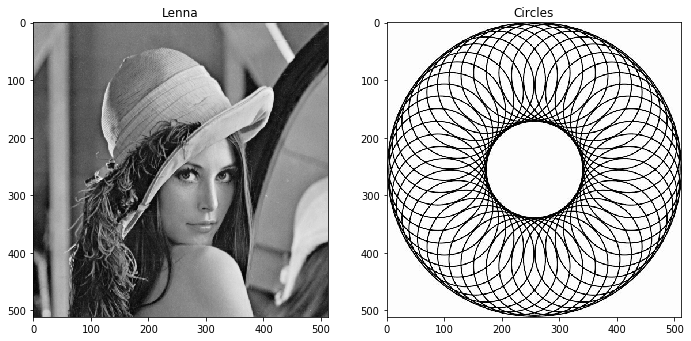

In [2]:
from matplotlib import pyplot as plt
from IPython.display import Image
import numpy as np
from numpy.linalg import inv
from scipy.fftpack import dst, idst
import pywt
import cv2
import math
import time

img = cv2.imread("Figures/Lenna.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img2 = cv2.imread("Figures/Circles.png")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

plt.figure(1)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(121) ,plt.imshow(img, cmap='gray')
plt.title('Lenna')
plt.subplot(122) ,plt.imshow(img2, cmap='gray')
plt.title('Circles')
plt.show()



<h1 style="font-size:180%; color:blue; text-align:center; line-height:45px;"> 1.1. Transformada de Walsh-Hadamard </h1>

<p style="font-size:135%;">La transformanda de Walsh-Hadamard, a diferencia de la transformada de Fourier, usa ondas rectangulares en el rango de $(-1,+1)$, contrario a las usualmente usadas ondas sinusoidales. Aunque cumple con las propiedades de ser simétrica y ortogonal, además su calculo es completamente basado en números reales. Su expresión de transformación directa e inversa se ilustran a continuación:</p>

<ul style="font-size:150%; text-align:center;">
    $WH(u,v) = \frac{1}{N} \sum_{x=0}^{N} \sum_{y=0}^{N} f(x,y)(-1)^{\sum_{i=0}^{n-1} b_i(x) p_i(u)+b_i(y) p_i(v)}$
</ul>

<ul style="font-size:150%; text-align:center;">
    $f(x,y) = \frac{1}{N} \sum_{x=0}^{N} \sum_{y=0}^{N} WH(u,v)(-1)^{\sum_{i=0}^{n-1} b_i(x) p_i(u)+b_i(y) p_i(v)}$
</ul>

<p style="font-size:135%;">
Estas expresiones pueden reducirse, hallando los coeficientes de transformación, a partir de una matriz de unos con un patrón de signos, por ejemplo, para el caso bidimensional básico se tiene la siguiente matriz:
</p>

<ul style="font-size:125%; text-align:center;">
$H_2 = \begin{bmatrix}
1 & 1\\ 
-1 & 1
\end{bmatrix}$
</ul>

<p style="font-size:135%;">
El patrón que sigue para coeficientes mayores es el siguiente:
</p>

<ul style="font-size:125%; text-align:center;">
$H_{2N} = \begin{bmatrix}
H_N & H_N\\ 
H_N & -H_N
\end{bmatrix}$
</ul>

<p style="font-size:135%;">
Como resultado del cálculo anticipado de los coeficientes, el cálculo de la transformada se vuelve mucho más rápido, reduciéndose a una multiplicación de matrices.
</p>

<ul style="font-size:125%; text-align:center;">
$A = \frac{1}{\sqrt{N}} H_N \Rightarrow T = AFA^{-1}$
</ul>

/home/michael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/home/michael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


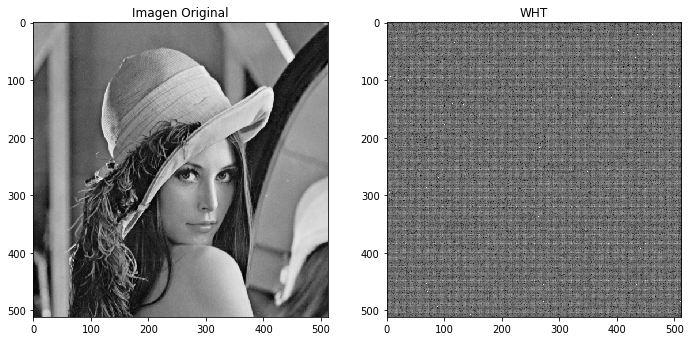

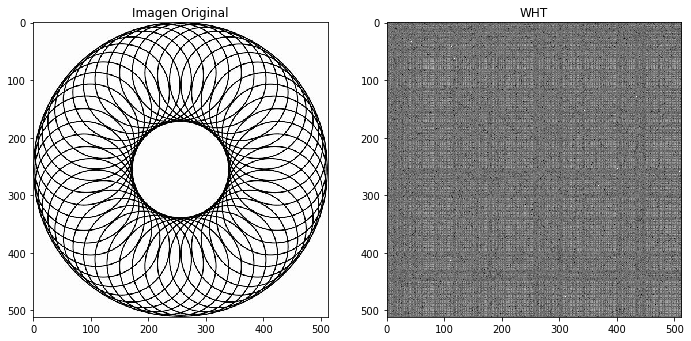

In [3]:
def H(n):    
    if n == 2:
        return np.matrix([[1, 1], [1,-1]])
    else:
        h = np.zeros((n,n))
        m = int(n/2)
        h[0:m,0:m] = H(m)
        h[m:n,0:m] = H(m)
        h[0:m,m:n] = H(m)
        h[m:n,m:n] = -H(m)
        return h
        
def WHT(img):
    n = img.shape[0]    
    h = H(n)
    ih = inv(h)
    T = np.dot(h, np.dot(img, ih))*1/(n)
    return T

def iWHT(T):
    n = T.shape[0]    
    h = H(n)
    ih = inv(h)
    nImg = np.dot(ih, np.dot(T, h))*1/(n)
    return nImg

tImg = WHT(img)
tImg = 20*np.log(np.abs(tImg))
plt.figure(1)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(121) , plt.imshow(img, cmap='gray')
plt.title('Imagen Original')
plt.subplot(122) , plt.imshow(tImg, cmap='gray')
plt.title('WHT')

tImg2 = WHT(img2)
reimg2 = iWHT(tImg2)
tImg2 = 20*np.log(np.abs(tImg2))
plt.figure(2)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(121) , plt.imshow(img2, cmap='gray')
plt.title('Imagen Original')
plt.subplot(122) , plt.imshow(tImg2, cmap='gray')
plt.title('WHT')

plt.show()



<h1 style="font-size:180%; color:blue; text-align:center; line-height:45px;"> 2. Compresión de Imágenes </h1>

<h1 style="font-size:150%; color:blue; text-align:left; line-height:45px;"> 2.1. Transformada de Fourier </h1>

<p style="font-size:135%;">Para la transformada de Fourier, se lleva una imagen base del dominio espacial a un dominio frecuencial, donde se toma una porción central de la imagen transformada y de esta subimagen se aplica la transformada de Fourier inversa para obtener la imagen comprimida. Dependiendo del tamaño de la porción de la imagen transformada, la imagen comprimida tendrá el mismo tamaño de la subimagen tomada, aunque hay que tomar en cuenta que a un menor tamaño se tiene mayor pérdida de calidad de la imagen comprimida.</p>

<p style="font-size:135%;">La librería OpenCV tiene una función de aplicación de transformada de Fourier conocida como dft2 o fft2, la cual se utilizará para aplicar la Transformada de Fourier y obtener una imagen comprimida.</p>

<p style="font-size:135%;">En el siguiente código, para una imagen de prueba se aplicará esta transformada y se visualizará como resultados a las imagen original, las imagen transformada, una porcion central de la imagen transformada y la imagen comprimida resultante de la aplicación de la transformada inversa de Fourier a la subimagen mencionada:</p>

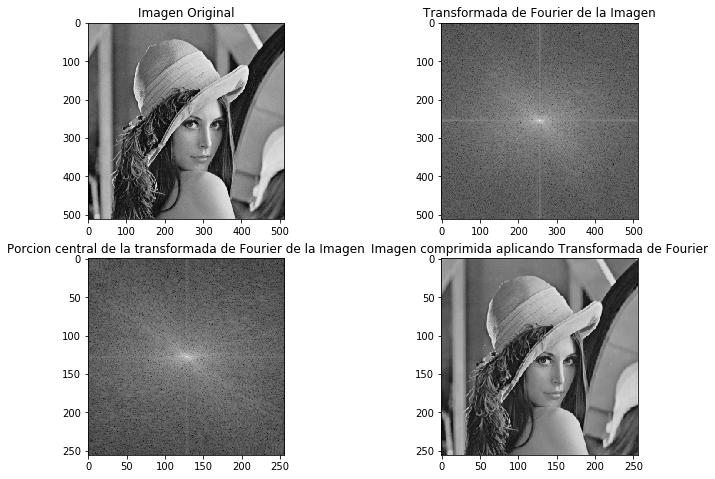

Tiempo de ejecución =  0.0406193733215332 segundos


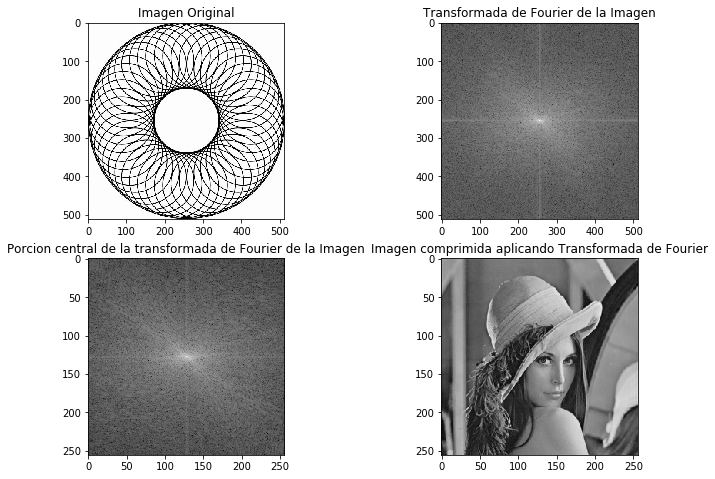

Tiempo de ejecución =  0.04305720329284668 segundos


In [4]:
def FourierCompression(img):
       
    h = img.shape[0]
    w = img.shape[1]
    
    cmpImage = np.zeros((h, w), np.uint8)  
    
    fft = np.fft.fft2(img)
    fshift = np.fft.fftshift(fft)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    fCmp = fshift[int(h/2-h/4):int(h/2+h/4), int(w/2-w/4):int(w/2+w/4)]
    submagnitude_spectrum = 20*np.log(np.abs(fCmp))
    
    ishift = np.fft.ifftshift(fCmp)
    cmp = np.fft.ifft2(ishift)
    cmp = np.abs(cmp)
    
    return magnitude_spectrum[:,:], submagnitude_spectrum[:,:], cmp

start = time.time()
magS, smagS, cmp = FourierCompression(img)
end = time.time()
exeTime = end - start

plt.figure(1)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(221) , plt.imshow(img, cmap='gray')
plt.title('Imagen Original')
plt.subplot(222) , plt.imshow(magS, cmap='gray')
plt.title('Transformada de Fourier de la Imagen')
plt.subplot(223) , plt.imshow(smagS, cmap='gray')
plt.title('Porcion central de la transformada de Fourier de la Imagen')
plt.subplot(224) , plt.imshow(cmp, cmap='gray')
plt.title('Imagen comprimida aplicando Transformada de Fourier')
plt.show()
print('Tiempo de ejecución = ', exeTime, 'segundos')

start = time.time()
magS2, smagS2, cmp2 = FourierCompression(img2)
end = time.time()
exeTime = end - start

plt.figure(2)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(221) , plt.imshow(img2, cmap='gray')
plt.title('Imagen Original')
plt.subplot(222) , plt.imshow(magS, cmap='gray')
plt.title('Transformada de Fourier de la Imagen')
plt.subplot(223) , plt.imshow(smagS, cmap='gray')
plt.title('Porcion central de la transformada de Fourier de la Imagen')
plt.subplot(224) , plt.imshow(cmp, cmap='gray')
plt.title('Imagen comprimida aplicando Transformada de Fourier')
plt.show()
print('Tiempo de ejecución = ', exeTime, 'segundos')

<h1 style="font-size:150%; color:blue; text-align:left; line-height:45px;"> 2.2. Transformada del Coseno (Algoritmo JPG) </h1>

<p style="font-size:135%;">Para la transformada de Coseno, se considera una matriz como kernel que ayudará a realizar la compresión de la imagen, esta matriz es de tamaño 8x8, por cada subimagen de tamaño 8x8 conexa, esta se considerará como una muestra, a la cual se aplica una operación de normalización componente a componente para aplicar la transformada coseno a esa muestra normalizada, luego, con la muestra normalizada se aplica un producto matricial junto al kernel, esta nueva subimagen resultante se normalizará y se le aplicará al resultando la transformada coseno inversa, y se toma la subimagen superior izquierda de tamaño 4x4 que hará parte de la imagen comprimida. A partir de los valores del kernel, la compresión aplicando la transformada coseno variará de resultado visualmente. Si intenta comparar el resultado de la compresión con la transformada de Fourier con la compresión con la transformada Coseno, se pueden notar diferencias en el resultado puesto que aplicando la transformada de Fourier o Wavelet visualmente se tiene un mejor nivel de detalle mientras que en este caso, se puede apreciar una pérdida de detalles en la imagen comprimida.</p>

<p style="font-size:135%;">La librería OpenCV tiene una función de aplicación de transformada de Coseno conocida como dct, la cual se utilizará para aplicar la Transformada de Coseno y obtener una imagen comprimida.</p>

<p style="font-size:135%;">En el siguiente código, para una imagen de prueba se aplicará esta transformada y se visualizará como resultados a las imagen original, el kernel y la imagen transformada:</p>

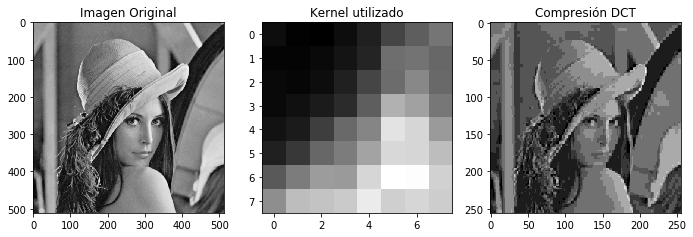

Tiempo de ejecución =  0.12003803253173828 segundos


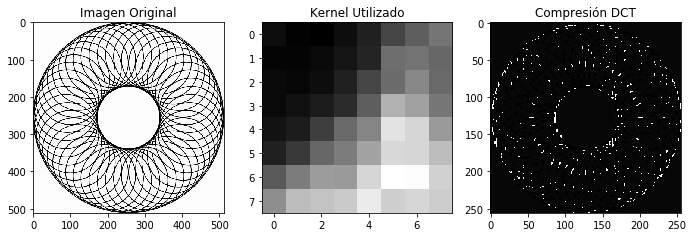

Tiempo de ejecución =  0.13068747520446777 segundos


In [5]:
def JPEG(img):
    
    qMtx = np.matrix('16 11 10 16 24 40 51 61;\
                      12 12 14 19 26 58 60 55;\
                      14 13 16 24 40 57 69 56;\
                      14 17 22 29 51 87 80 62;\
                      18 22 37 56 68 109 103 77;\
                      24 35 55 64 81 104 103 92;\
                      49 64 78 77 103 121 120 101;\
                      72 92 95 98 112 100 103 99').astype('float32')
    n = len(qMtx)    
    h = img.shape[0]
    w = img.shape[1]
    
    nc = int(len(qMtx)/2)
    hc = math.floor(h/2)
    wc = math.floor(w/2)
    
    cmpImage = np.zeros((hc, wc), np.uint8)  
    for i in range(0, math.floor(h/n)):
        for j in range(0, math.floor(w/n)):
            sample = img[i*n:i*n+8,j*n:j*n+8]
            imf = np.float32(sample)/255.0
            dct = cv2.dct(imf)
            qDct = (dct*127/qMtx).astype(int)
            idct = cv2.idct(np.float32(qDct)/255.0) 
            cmpImage[i*nc:i*nc+4,j*nc:j*nc+4] = (idct[0:4,0:4]*255).astype(int)
    return qMtx, cmpImage

start = time.time()
kern, cmp = JPEG(img)
end = time.time()
exeTime = end - start

plt.figure(1)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(131) , plt.imshow(img, cmap='gray')
plt.title('Imagen Original')
plt.subplot(132) , plt.imshow(kern, cmap='gray')
plt.title('Kernel utilizado')
plt.subplot(133) , plt.imshow(cmp, cmap='gray')
plt.title('Compresión DCT')
plt.show()

print('Tiempo de ejecución = ', exeTime, 'segundos')

start = time.time()
kern2, cmp2 = JPEG(img2)
end = time.time()
exeTime = end - start

plt.figure(2)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(131) , plt.imshow(img2, cmap='gray')
plt.title('Imagen Original')
plt.subplot(132) , plt.imshow(kern2, cmap='gray')
plt.title('Kernel Utilizado')
plt.subplot(133) , plt.imshow(cmp2, cmap='gray')
plt.title('Compresión DCT')
plt.show()

print('Tiempo de ejecución = ', exeTime, 'segundos')



<h1 style="font-size:150%; color:blue; text-align:left; line-height:45px;"> 2.3. Transformada Seno </h1>

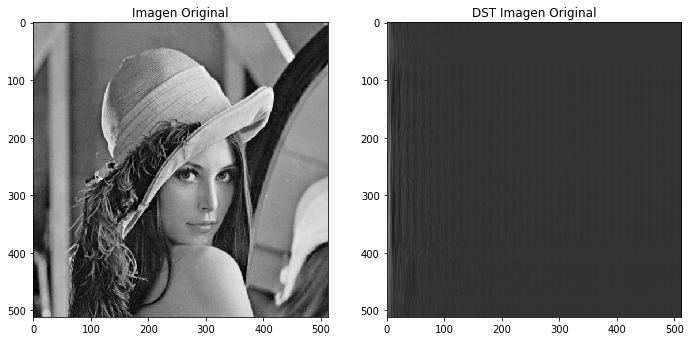

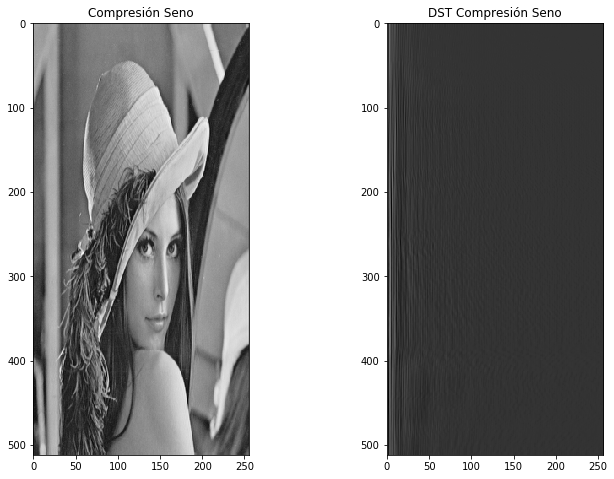

In [6]:
def cDST(img):
    T = dst(img)
    n = int(len(img)/2)
    rT = T[0:len(img),0:n]
    return idst(rT)
    
cmp = cDST(img)
    
plt.figure(1)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(121) , plt.imshow(img, cmap='gray')
plt.title('Imagen Original')
plt.subplot(122) , plt.imshow(dst(img), cmap='gray')
plt.title('DST Imagen Original')

plt.figure(2)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(121) , plt.imshow(cmp, cmap='gray')
plt.title('Compresión Seno')
plt.subplot(122) , plt.imshow(dst(cmp), cmap='gray')
plt.title('DST Compresión Seno')
plt.show()    
    

<h1 style="font-size:150%; color:blue; text-align:left; line-height:45px;"> 2.4. Transformada Wavelet </h1>

<p style="font-size:135%;">Para la transformada Wavelet, en este caso solo se hace un escalado de un nivel, es decir, las dimensiones en ancho y alto de la imagen se van a reducir a la mitad. Para compresión de imágenes, esta transformada se puede asimilar a una operación en la que el nuevo pixel tendría como color a un promedio con cierta ponderación de 2 pixeles de la imagen original, es decir, a parte de comprimir la imagen a la mitad de dimensiones, se podrá apreciar un ligero filtro pasabajo aplicado. Visualmente, esta transformada puede comprimir imágenes sin tan ta pérdida de calidad, lo cual es un buen resultado.</p>

<p style="font-size:135%;">La librería Pywt tiene una función de aplicación de transformada Wavelet conocida como wavedec2, la cual se utilizará para aplicar la Transformada Wavelet y obtener una imagen comprimida.</p>

<p style="font-size:135%;">En el siguiente código, para una imagen de prueba se aplicará esta transformada a un nivel (Reducción de ancho y alto a la mitad) y se visualizará como resultado a las imagen original y la imagen transformada:</p>

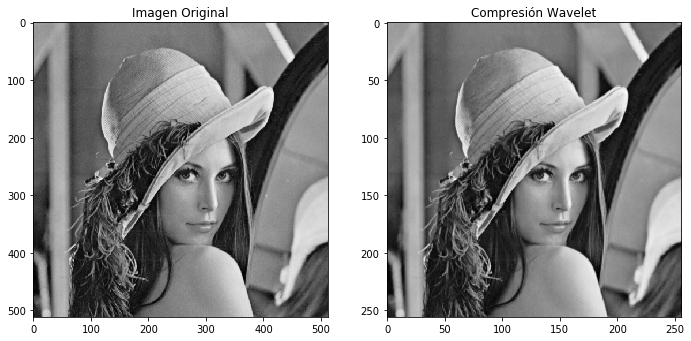

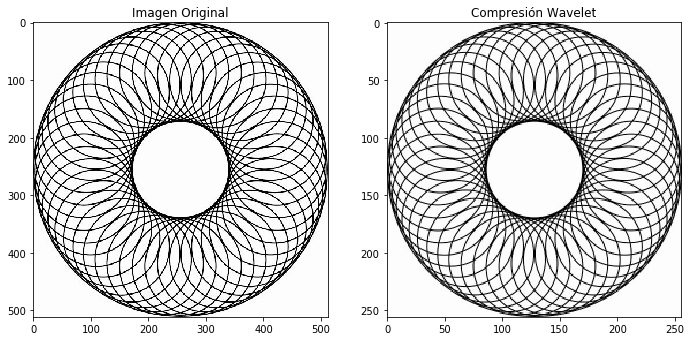

Tiempo de ejecución =  0.010879993438720703 segundos


In [7]:
def w2d(img, mode='haar', level=1):    
    coeffs=pywt.wavedec2(img, mode, level=level)
    return coeffs[0]

dwtImg = w2d(img)

start = time.time()
cmp = w2d(img)
end = time.time()
exeTime = end - start

plt.figure(1)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(121) , plt.imshow(img, cmap='gray')
plt.title('Imagen Original')
plt.subplot(122) , plt.imshow(cmp, cmap='gray')
plt.title('Compresión Wavelet')
plt.show()

start = time.time()
cmp2 = w2d(img2)
end = time.time()
exeTime = end - start

plt.figure(2)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(121) , plt.imshow(img2, cmap='gray')
plt.title('Imagen Original')
plt.subplot(122) , plt.imshow(cmp2, cmap='gray')
plt.title('Compresión Wavelet')
plt.show()

print('Tiempo de ejecución = ', exeTime, 'segundos')

<h1 style="font-size:240%; color:blue; text-align:center; line-height:45px;"> 3. Reducción de Ruido en Imágenes </h1>

<p style="font-size:135%;">En el siguiente código, se preparan unas imágenes con ruido aplicado para visualizar el desempeño de los filtros mostrados en la reducción de este ruido:</p>

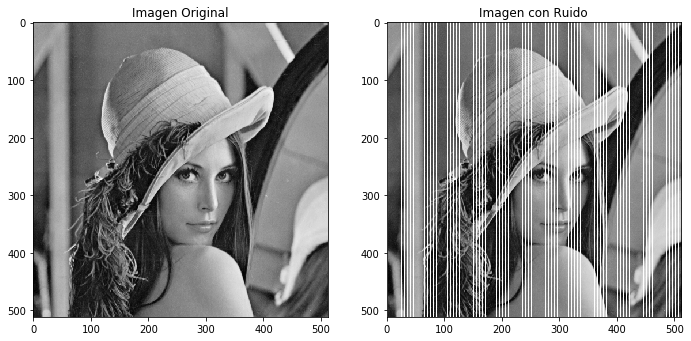

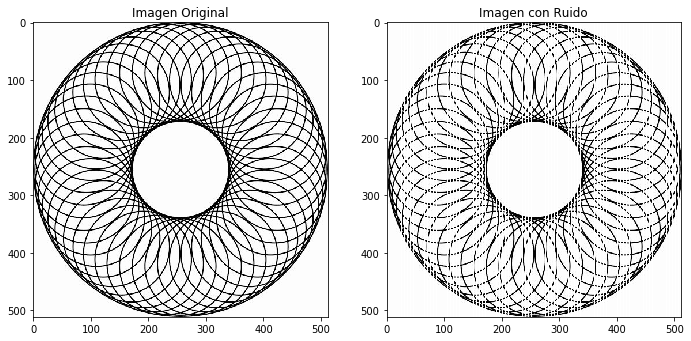

In [8]:
def noisy(img):
    out = np.copy(img)
    for y in range(len(img)):
        for x in range(len(img)):            
            if (y % 5) == 0:
                out[x,y] = 255
    return out


nImg = noisy(img)
plt.figure(1)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(121) , plt.imshow(img, cmap='gray')
plt.title('Imagen Original')
plt.subplot(122) , plt.imshow(nImg, cmap='gray')
plt.title('Imagen con Ruido')
plt.show()

nImg2 = noisy(img2)
plt.figure(2)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(121) , plt.imshow(img2, cmap='gray')
plt.title('Imagen Original')
plt.subplot(122) , plt.imshow(nImg2, cmap='gray')
plt.title('Imagen con Ruido')
plt.show()


<h1 style="font-size:150%; color:blue; text-align:left; line-height:45px;"> 3.1. Transformada Coseno </h1>

<p style="font-size:135%;">Para la transformada Coseno, en este caso, la imagen original inicialmente se normaliza, luego se aplica la transformada Coseno directa, y a la imagen obtenida, se aplica un umbral para frecuencia baja y alta para tomar solamente la imagen que se adapte a este umbral (Dado que se manejará un umbral para frecuencias bajas y altas, este filtro será pasabandas), luego, esta imagen umbralizada se desnormalizará (Se pasa de valor máximo de 1 a un valor máximo de 255), y se aplicará la transformada coseno inversa.</p>

<p style="font-size:135%;">La librería OpenCV tiene una función de aplicación de transformada Coseno conocida como dct, la cual se utilizará para aplicar la Transformada Coseno y obtener una imagen filtrada con ruido reducido.</p>

<p style="font-size:135%;">Visualmente, se puede apreciar que el filtro definido con esta transformada es bueno puesto que no se evidencia el ruido en un porcentaje significativo comparado con la imagen con ruido original, aunque a una mayor reducción de estos ruidos, se notará un efecto de mayor borrosidad en la imagen debido a otras altas frecuencias como los contornos.</p>

<p style="font-size:135%;">En el siguiente código, para una imagen de prueba con y sin ruido, se aplicará esta transformada y se visualizará como resultado a las imagen original, la imagen transformada y la imagen filtrada.</p>

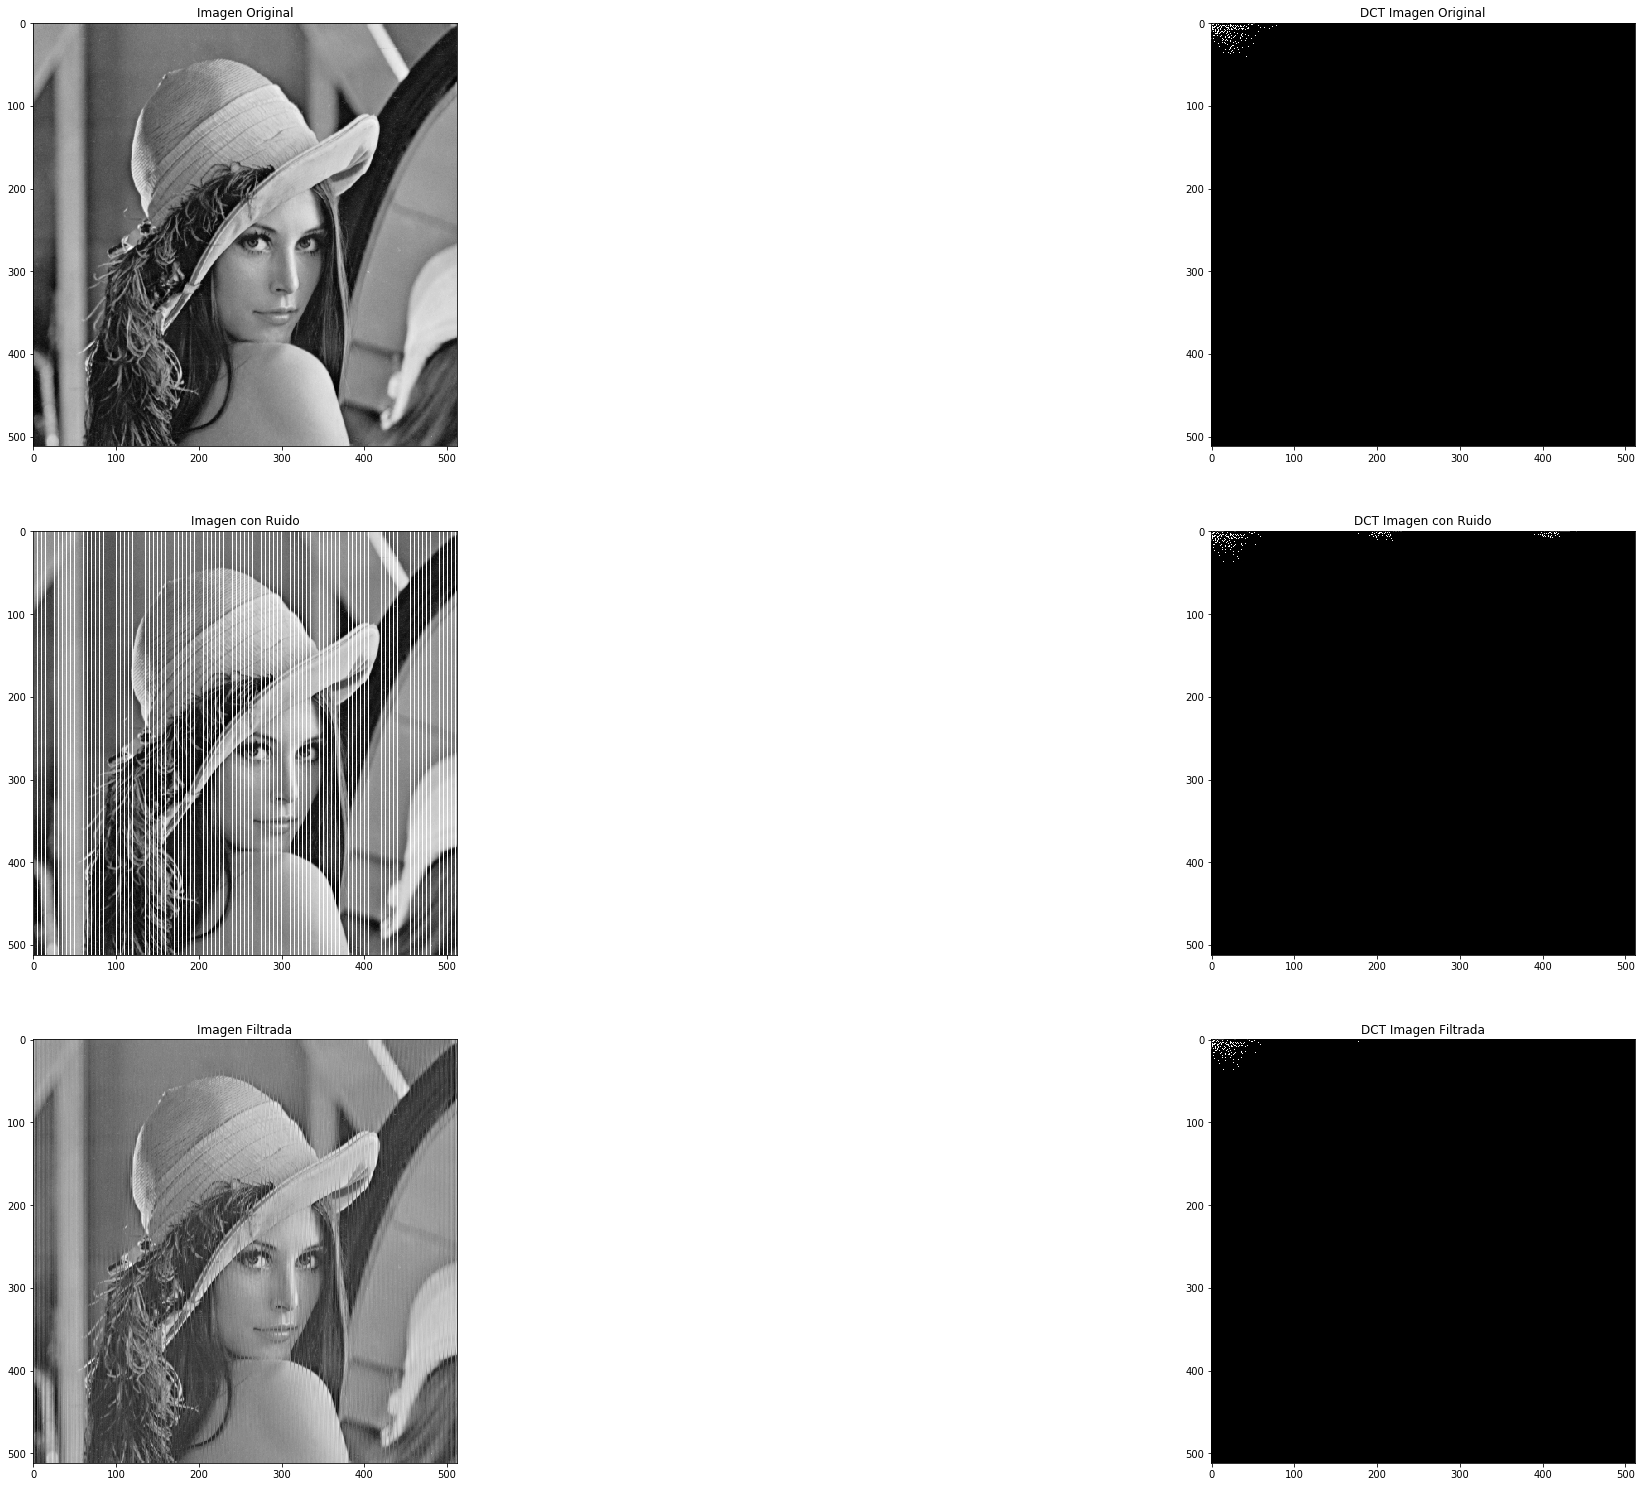

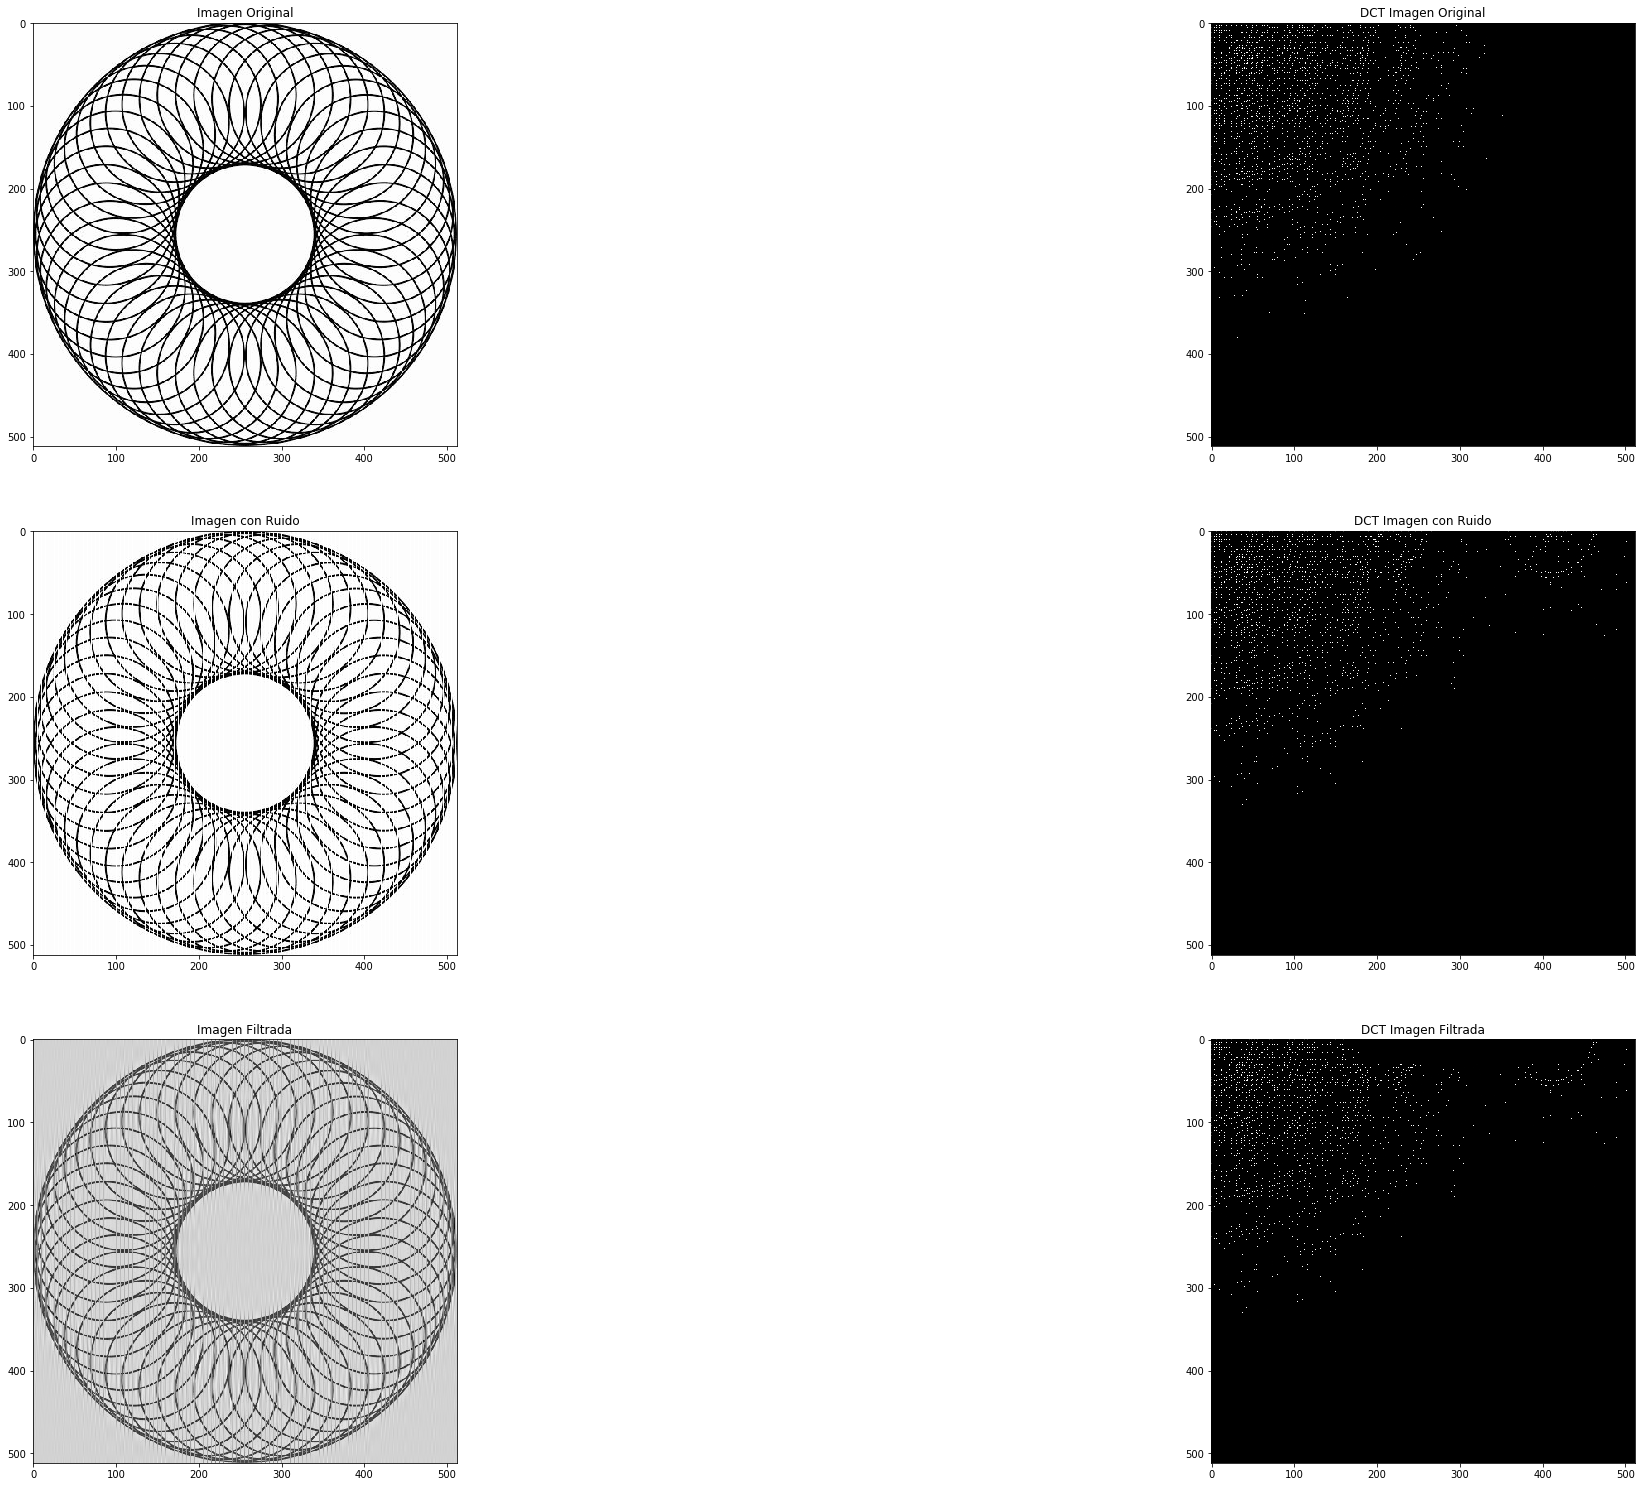

In [9]:
def DCT(img):
    T = np.float32(img)/255.0
    dct = cv2.dct(T)
    odct = np.uint8(dct)*255.0 
    return odct

def fDCT(img, x, y):
    T = np.float32(img)/255.0
    dct = cv2.dct(T)    
    dct[x[0]:x[1],y[0]:y[1]] = 0
    odct = np.uint8(dct)*255.0 
    fImg = cv2.idct(np.float32(dct)/255.0) 
    return fImg, odct

dctImg = DCT(img)
dctNImg = DCT(nImg)
flt, fdct = fDCT(nImg, (0,30), (180,450))

plt.figure(1)
plt.subplots_adjust(left=0.0, right=5.0, bottom=0.0, top=5.0)
plt.subplot(321) , plt.imshow(img, cmap='gray')
plt.title('Imagen Original')
plt.subplot(322) , plt.imshow(dctImg, cmap='gray')
plt.title('DCT Imagen Original')
plt.subplot(323) , plt.imshow(nImg, cmap='gray')
plt.title('Imagen con Ruido')
plt.subplot(324) , plt.imshow(dctNImg, cmap='gray')
plt.title('DCT Imagen con Ruido')
plt.subplot(325) , plt.imshow(flt, cmap='gray')
plt.title('Imagen Filtrada')
plt.subplot(326) , plt.imshow(fdct, cmap='gray')
plt.title('DCT Imagen Filtrada')

dctImg = DCT(img2)
dctNImg = DCT(nImg2)
flt, fdct = fDCT(nImg2, (0,30), (180,450))

plt.figure(2)
plt.subplots_adjust(left=0.0, right=5.0, bottom=0.0, top=5.0)

plt.subplot(321) , plt.imshow(img2, cmap='gray')
plt.title('Imagen Original')
plt.subplot(322) , plt.imshow(dctImg, cmap='gray')
plt.title('DCT Imagen Original')
plt.subplot(323) , plt.imshow(nImg2, cmap='gray')
plt.title('Imagen con Ruido')
plt.subplot(324) , plt.imshow(dctNImg, cmap='gray')
plt.title('DCT Imagen con Ruido')
plt.subplot(325) , plt.imshow(flt, cmap='gray')
plt.title('Imagen Filtrada')
plt.subplot(326) , plt.imshow(fdct, cmap='gray')
plt.title('DCT Imagen Filtrada')

plt.show()




<h1 style="font-size:150%; color:blue; text-align:left; line-height:45px;"> 2.3.2 Filtrado DST </h1>

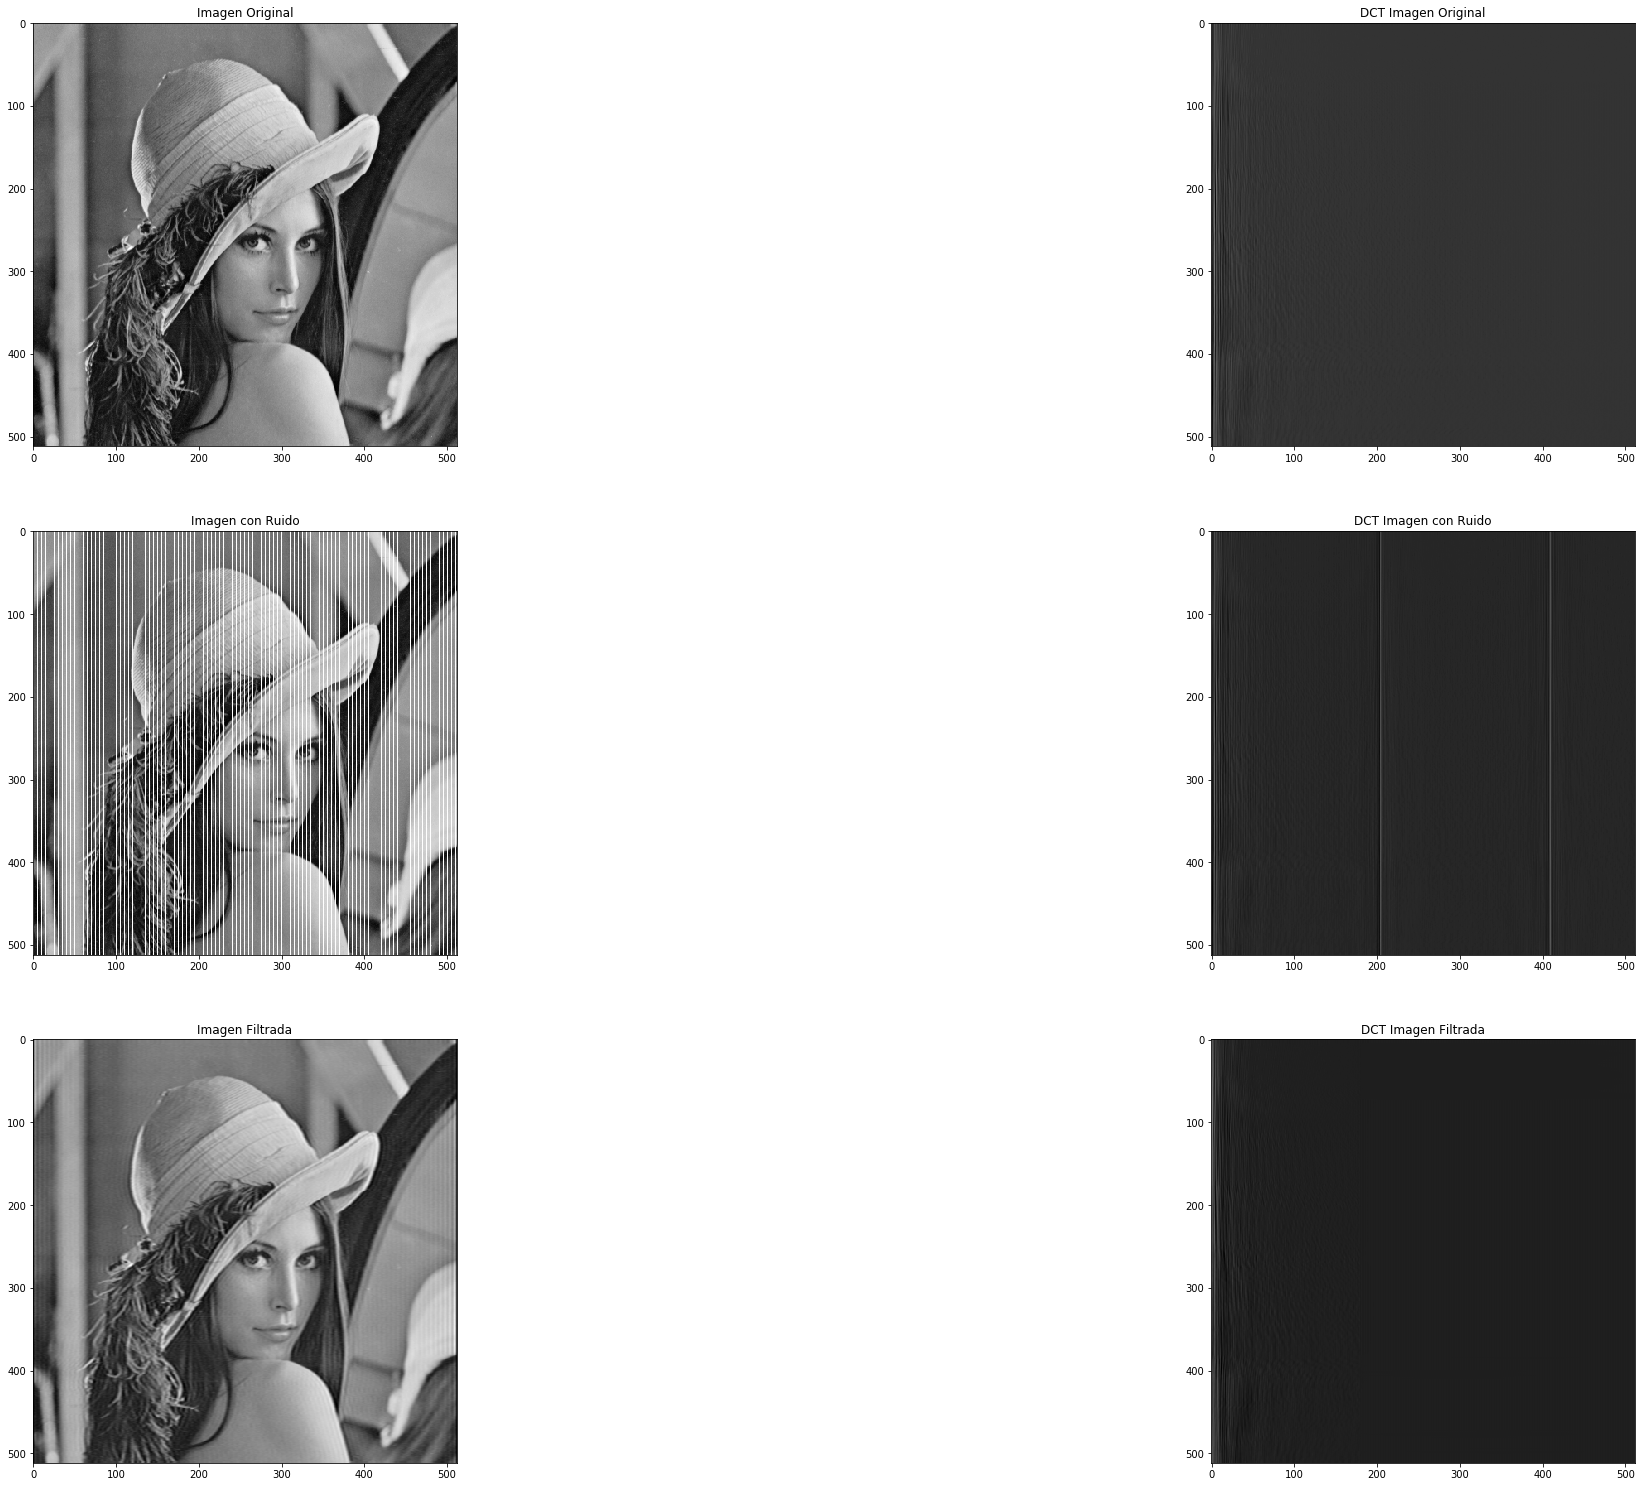

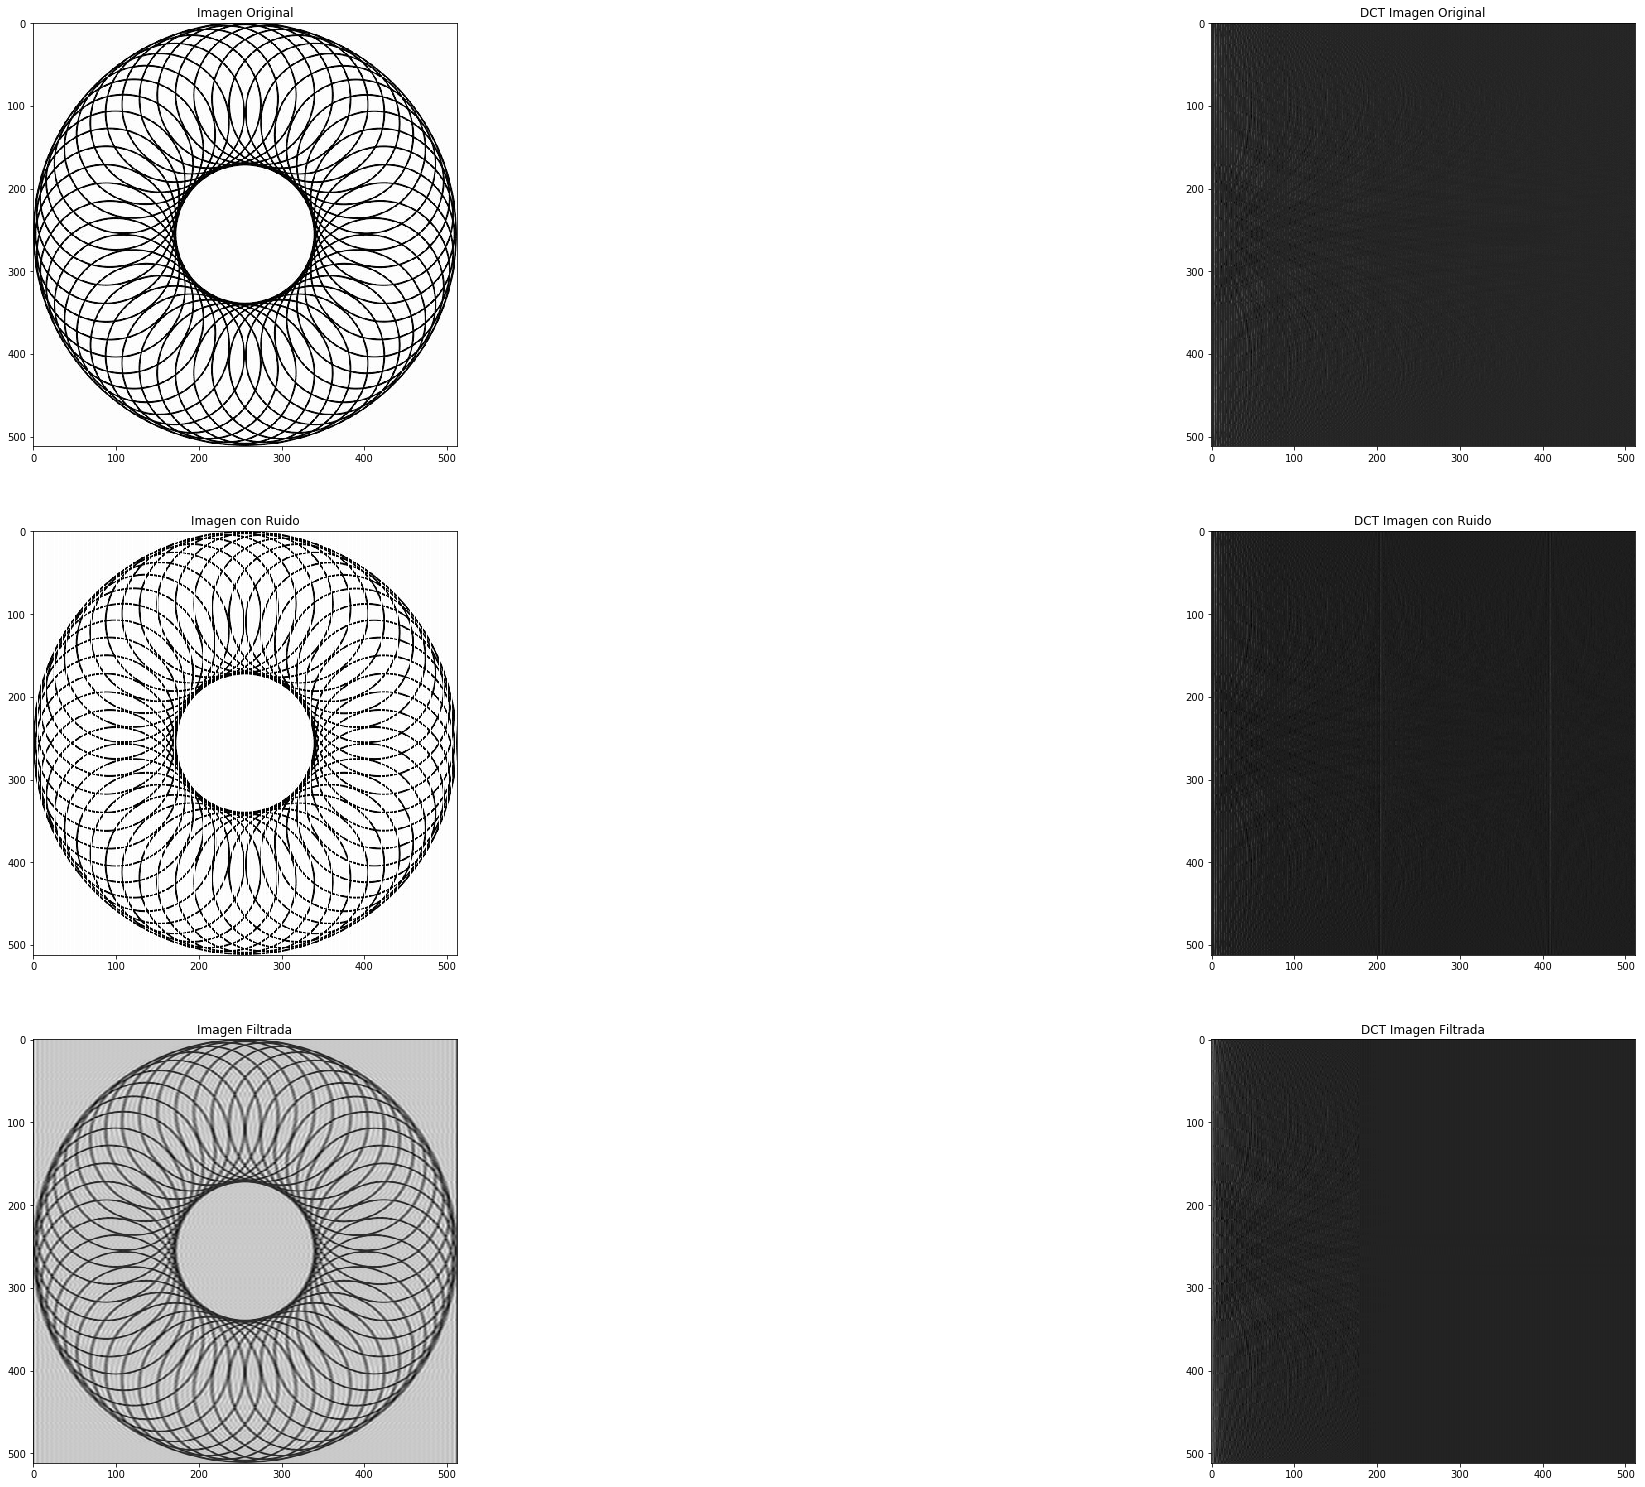

In [10]:
def fDST(img):
    T = dst(img)
    T[0:len(img),180:len(img)] = 0
    return idst(T)

fImg = fDST(img)

plt.figure(1)
plt.subplots_adjust(left=0.0, right=5.0, bottom=0.0, top=5.0)
plt.subplot(321) , plt.imshow(img, cmap='gray')
plt.title('Imagen Original')
plt.subplot(322) , plt.imshow(dst(img), cmap='gray')
plt.title('DCT Imagen Original')
plt.subplot(323) , plt.imshow(nImg, cmap='gray')
plt.title('Imagen con Ruido')
plt.subplot(324) , plt.imshow(dst(nImg), cmap='gray')
plt.title('DCT Imagen con Ruido')
plt.subplot(325) , plt.imshow(fImg, cmap='gray')
plt.title('Imagen Filtrada')
plt.subplot(326) , plt.imshow(idst(fImg), cmap='gray')
plt.title('DCT Imagen Filtrada')

fImg = fDST(img2)

plt.figure(2)
plt.subplots_adjust(left=0.0, right=5.0, bottom=0.0, top=5.0)
plt.subplot(321) , plt.imshow(img2, cmap='gray')
plt.title('Imagen Original')
plt.subplot(322) , plt.imshow(dst(img2), cmap='gray')
plt.title('DCT Imagen Original')
plt.subplot(323) , plt.imshow(nImg2, cmap='gray')
plt.title('Imagen con Ruido')
plt.subplot(324) , plt.imshow(dst(nImg2), cmap='gray')
plt.title('DCT Imagen con Ruido')
plt.subplot(325) , plt.imshow(fImg, cmap='gray')
plt.title('Imagen Filtrada')
plt.subplot(326) , plt.imshow(idst(fImg), cmap='gray')
plt.title('DCT Imagen Filtrada')
plt.show()

<h1 style="font-size:150%; color:blue; text-align:left; line-height:45px;"> 3.3. Transformada de Haar (Subtransformada Wavelet) </h1>

<p style="font-size:135%;">Tomando en cuenta que la transformada de Haar es una operación en la que se aplican operaciones de promedio de números, entonces, a partir de esto, se define una funcion de efecto borroso que permite reducir el ruido de una imagen en la que dependiendo de una longitud de kernel, la reducción de ruido será mayor pero a la vez se tendrá mayor borrosidad visualmente en la imagen filtrada como consecuencia de eliminación de ruidos (Como pérdida de detalles en contornos (Altas frecuencias), ruidos debido a fenónemos electromagnéticos, ruidos agregados como Sal y Pimienta, etc.). A grosso modo, para cada pixel se tiene que su nuevo color es el valor promedio de color de sus pixeles vecinos alrededor donde a mayor longitud de kernel, mayor será la cobertura de vecinos.</p>

<p style="font-size:135%;">Cabe destacar que la librería OpenCV tiene una función de aplicación de efecto borroso conocida como medianBlur, pero la diferencia radica básicamente en que la función definida en el siguiente código usa como operación al promedio o media aritmética y la función medianBlur usa como operación a la mediana.</p>

<p style="font-size:135%;">Respecto al comportamiento de esta transformada en el filtro de reducción de ruido implementado, no se trabaja en un dominio frecuencial, sino que las operaciones o cálculos se hacen con la imagen en el dominio espacial y el desempeño de este filtrado en su tiempo de ejecución se considera lineal puesto que al operar pixel a pixel se realizan cálculos computacionales sencillos (Un número fijo de sumas y Divisiones de valores puntuales (Colores del pixel)).</p>

<p style="font-size:135%;">En el siguiente código, para 2 imágenes que tienen ruidos bastante altos, se aplicará este filtro y se visualizarán como resultados a las imágenes originales, las imágenes filtradas, una porción de las imágenes originales con su respectivo resultado de filtro con una longitud de kernel baja que elimine los ruidos altos y a la vez pueda conservar detalles como contornos:</p>

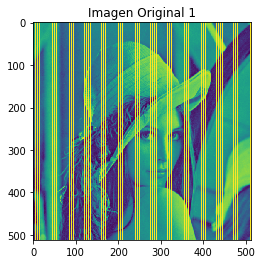

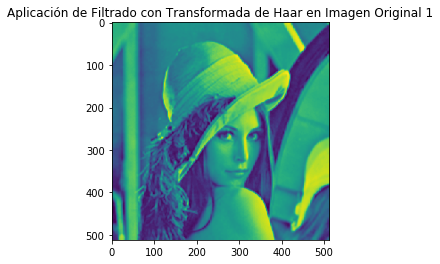

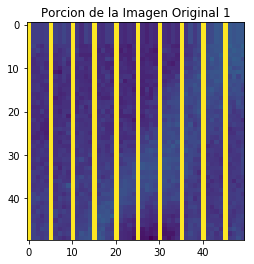

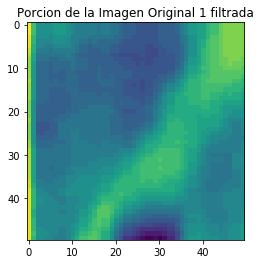

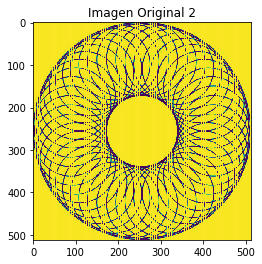

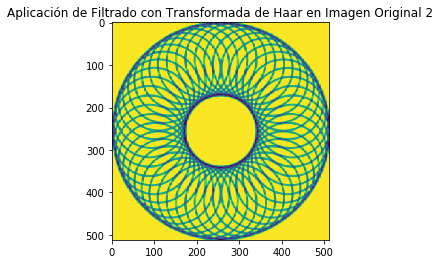

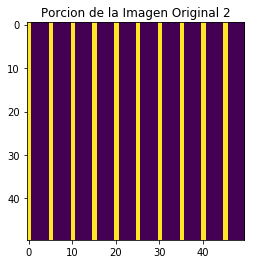

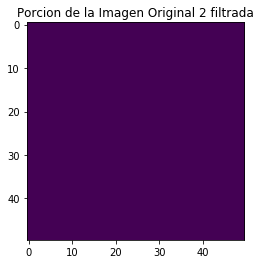

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

longitudKernel = 5

def efectoBorroso(imagenOriginal, altoImagen, anchoImagen, longitudKernel):
    #imagenResultante = np.zeros((altoImagen, anchoImagen, 3), np.uint8)
    imagenResultante = np.zeros((altoImagen, anchoImagen), np.uint8)
    if longitudKernel < 3 or longitudKernel % 2 == 0:
        print ("No se puede aplicar efecto borroso")
    pixelesRadio = (longitudKernel - 1) / 2
    for r in range(0, altoImagen):
        if r - pixelesRadio >= 0:
            top = r - pixelesRadio
        else:
            top = 0
        if r + pixelesRadio < altoImagen:
            bottom = r + pixelesRadio
        else:
            bottom = altoImagen - 1
        for c in range(0, anchoImagen):
            if c - pixelesRadio >= 0:
                left = c - pixelesRadio
            else:
                left = 0
            if c + pixelesRadio < anchoImagen:
                right = c + pixelesRadio
            else:
                right = anchoImagen - 1
            anchoRectangulo = right - left + 1
            altoRectangulo = bottom - top + 1
            color1 = 0
            #color2 = 0
            #color3 = 0
            for aa in range(int(left), int(left) + int(anchoRectangulo)):
                for bb in range(int(top), int(top) + int(altoRectangulo)):
                    color1 += imagenOriginal[bb][aa]
                    #color1 += imagenOriginal[bb][aa][0]
                    #color2 += imagenOriginal[bb][aa][1]
                    #color3 += imagenOriginal[bb][aa][2]
            color1 = color1 / (anchoRectangulo * altoRectangulo)
            #color2 = color2 / (anchoRectangulo * altoRectangulo)
            #color3 = color3 / (anchoRectangulo * altoRectangulo)
            imagenResultante[r][c] = color1
            #imagenResultante[r][c][0] = color1
            #imagenResultante[r][c][1] = color2
            #imagenResultante[r][c][2] = color3
    return imagenResultante

imagenOriginal1 = nImg
muestraImagenOriginal1 = imagenOriginal1[0:50, 0:50]
imagenOriginal2 = nImg2
muestraImagenOriginal2 = imagenOriginal2[0:50, 0:50]

#Reconocimiento de las dimensiones de la imagen original (Pixeles de ancho y de alto)
altoImagen1, anchoImagen1 = imagenOriginal1.shape[:2]
altoImagen2, anchoImagen2 = imagenOriginal2.shape[:2]

imagenRes1 = efectoBorroso(imagenOriginal1, altoImagen1, anchoImagen1, longitudKernel)
imagenRes2 = efectoBorroso(imagenOriginal2, altoImagen2, anchoImagen2, longitudKernel)

muestraImagenRes1 = imagenRes1[0:50, 0:50]
muestraImagenRes2 = imagenRes2[0:50, 0:50]

plt.figure(1001)
plt.subplot(111)
plt.imshow(imagenOriginal1)
plt.title('Imagen Original 1')
plt.show()
plt.subplot(111)
plt.imshow(imagenRes1)
plt.title('Aplicación de Filtrado con Transformada de Haar en Imagen Original 1')
plt.show()
plt.subplot(111)
plt.imshow(muestraImagenOriginal1)
plt.title('Porcion de la Imagen Original 1')
plt.show()
plt.subplot(111)
plt.imshow(muestraImagenRes1)
plt.title('Porcion de la Imagen Original 1 filtrada')
plt.show()
plt.subplot(111)
plt.imshow(imagenOriginal2)
plt.title('Imagen Original 2')
plt.show()
plt.subplot(111)
plt.imshow(imagenRes2)
plt.title('Aplicación de Filtrado con Transformada de Haar en Imagen Original 2')
plt.show()
plt.subplot(111)
plt.imshow(muestraImagenOriginal2)
plt.title('Porcion de la Imagen Original 2')
plt.show()
plt.subplot(111)
plt.imshow(muestraImagenRes2)
plt.title('Porcion de la Imagen Original 2 filtrada')
plt.show()


<h1 style="font-size:150%; color:blue; text-align:left; line-height:45px;"> 3.4. Transformada de Fourier </h1>

<p style="font-size:135%;">Para la transformada de Fourier, en este caso se lleva una imagen base del dominio espacial a un dominio frecuencial (Este paso no sucede en la transformada de Haar) donde las altas frecuencias se pueden interpretar como ruido (Ya sea por agregación de ruidos aleatoriamente como Gaussiano o Sal y Pimienta, identificación de contornos, etc.), estas altas freuencias son las que se eliminarían aplicando a la imagen transformada una máscara (Esta máscara será una imagen negra con una porción central con un color distinto de 0), y luego se aplicará a la imagen obtenida la transformada de Fourier inversa para obtener una imagen filtrada. Aunque se eliminen ruidos no deseados, también se pierde detalle en los contornos y la imagen resultante se verá borrosa.</p>

<p style="font-size:135%;">Cabe destacar que la librería OpenCV tiene una función de aplicación de transformada de Fourier conocida como dft2, la cual se utilizará para diseñar un filtro de reducción de ruido.</p>

<p style="font-size:135%;">En el siguiente código, para una imagen que tiene ruido bastante alto, se aplicará este filtro y se visualizará como resultados a las imágenes originales, las imágenes filtradas, la máscara que se usará para obtener la imagen filtrada y una porción de la imagen original con su respectivo resultado de filtro.</p>

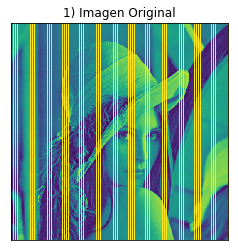

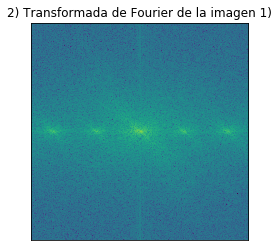

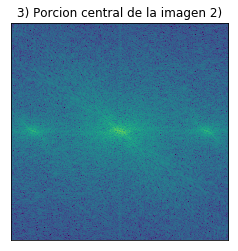

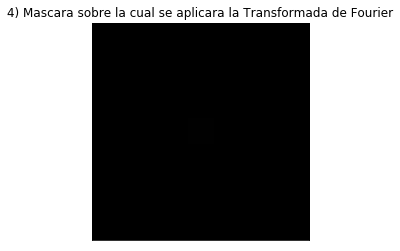

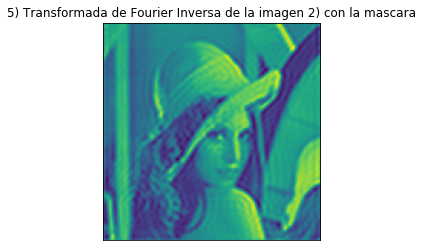

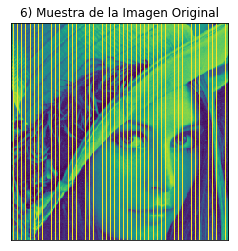

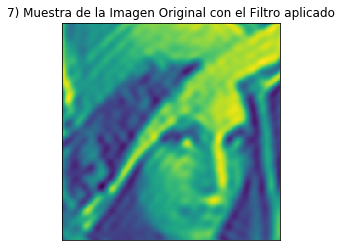

In [15]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = nImg
altoImagen, anchoImagen = img.shape[:2]

muestraImg = img[int(altoImagen / 4) : int(3 * altoImagen / 4) + 1, int(anchoImagen / 4) : int(3 * anchoImagen / 4) + 1]

dft = cv2.dft(np.float32(img), flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]))

muestraImgSpec = magnitude_spectrum[int(altoImagen / 4) : int(3 * altoImagen / 4) + 1, int(anchoImagen / 4) : int(3 * anchoImagen / 4) + 1]

plt.figure(1003)
plt.subplot(111), plt.imshow(img)
plt.title('1) Imagen Original'), plt.xticks([]), plt.yticks([])
plt.show()
plt.subplot(111), plt.imshow(magnitude_spectrum)
plt.title('2) Transformada de Fourier de la imagen 1)'), plt.xticks([]), plt.yticks([])
plt.show()
plt.subplot(111), plt.imshow(muestraImgSpec)
plt.title('3) Porcion central de la imagen 2)'), plt.xticks([]), plt.yticks([])
plt.show()

rows, cols = img.shape[:2]
crow,ccol = rows/2 , cols/2

#Creacion de una mascara en la que los pixeles centrales valen 1 y los demas pixeles valen 0 (Para visualizacion)
mask = np.zeros((rows,cols,3), np.uint8)
mask[int(crow) - 30 : int(crow) + 30, int(ccol) - 30 : int(ccol) + 30] = 1

plt.subplot(111), plt.imshow(mask)
plt.title('4) Mascara sobre la cual se aplicara la Transformada de Fourier'), plt.xticks([]), plt.yticks([])
plt.show()

#Creacion de una mascara en la que el pixel central vale 1 y los demas pixeles valen 0 (Para aplicacion de la transformada)
mask = np.zeros((rows,cols,2), np.uint8)
mask[int(crow) - 30 : int(crow) + 30, int(ccol) - 30 : int(ccol) + 30] = 1

#Aplicacion de la mascara y posterior a eso la DFT inversa
fshift = dft_shift * mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])

muestraRes = img_back[int(altoImagen / 4) : int(3 * altoImagen / 4) + 1, int(anchoImagen / 4) : int(3 * anchoImagen / 4) + 1]

plt.subplot(111), plt.imshow(img_back)
plt.title('5) Transformada de Fourier Inversa de la imagen 2) con la mascara'), plt.xticks([]), plt.yticks([])
plt.show()

plt.subplot(111), plt.imshow(muestraImg)
plt.title('6) Muestra de la Imagen Original'), plt.xticks([]), plt.yticks([])
plt.show()

plt.subplot(111), plt.imshow(muestraRes)
plt.title('7) Muestra de la Imagen Original con el Filtro aplicado'), plt.xticks([]), plt.yticks([])
plt.show()